In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import calculate_metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_pickle('data/dataset/cleandata.pkl')
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


### Feacture Engineering

* Decide which column I need for model building 
* And drop the column I dont need for model building
* Encode the column needed for model training 

In [3]:
df = df.drop(columns=['accountNumber', 'customerId', 'creditLimit', 'availableMoney', 'currentExpDate',
                 'accountOpenDate', 'dateOfLastAddressChange', 'transactionDateTime', 'transactionType', 'merchantName'],  axis=1)

In [4]:
df.head()

,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,98.55,US,US,02,01,rideshare,414,414,1803,0.0,False,False,False
1,74.51,US,US,09,01,entertainment,486,486,767,0.0,True,False,False
2,7.47,US,US,09,01,mobileapps,486,486,767,0.0,False,False,False
3,7.47,US,US,09,01,mobileapps,486,486,767,0.0,False,False,False
4,71.18,US,US,02,01,fastfood,885,885,3143,0.0,True,False,False


In [5]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Selecting only columns with data type 'object' or 'category'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Encode each categorical column
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [6]:
df.head()

,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,98.55,3,3,0,0,17,414,414,1803,0.0,False,False,False
1,74.51,3,3,2,0,3,486,486,767,0.0,True,False,False
2,7.47,3,3,2,0,12,486,486,767,0.0,False,False,False
3,7.47,3,3,2,0,12,486,486,767,0.0,False,False,False
4,71.18,3,3,0,0,4,885,885,3143,0.0,True,False,False


In [7]:
# Assuming 'numerical_columns' is a list of numerical column names
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Min-Max scaling
min_max_scaler = MinMaxScaler()
df[numerical_columns] = min_max_scaler.fit_transform(df[numerical_columns])

# Standardization (z-score normalization)
standard_scaler = StandardScaler()
df[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])

In [8]:
df.head()

,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,-0.260184,0.059031,0.085078,-1.250107,-0.485665,1.386171,-0.498873,-0.497738,-0.985929,-0.698224,False,False,False
1,-0.422918,0.059031,0.085078,0.858466,-0.485665,-1.241932,-0.223564,-0.222457,-1.331657,-0.698224,True,False,False
2,-0.876733,0.059031,0.085078,0.858466,-0.485665,0.447563,-0.223564,-0.222457,-1.331657,-0.698224,False,False,False
3,-0.876733,0.059031,0.085078,0.858466,-0.485665,0.447563,-0.223564,-0.222457,-1.331657,-0.698224,False,False,False
4,-0.445460,0.059031,0.085078,-1.250107,-0.485665,-1.054210,1.302108,1.303058,-0.538753,-0.698224,True,False,False


In [9]:
# List of binary columns to map
binary_columns = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']

# Apply mapping to each binary column
for column in binary_columns:
    df[column] = df[column].map({True: 1, False: 0})


In [10]:
df.head()

,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,-0.260184,0.059031,0.085078,-1.250107,-0.485665,1.386171,-0.498873,-0.497738,-0.985929,-0.698224,0,0,0
1,-0.422918,0.059031,0.085078,0.858466,-0.485665,-1.241932,-0.223564,-0.222457,-1.331657,-0.698224,1,0,0
2,-0.876733,0.059031,0.085078,0.858466,-0.485665,0.447563,-0.223564,-0.222457,-1.331657,-0.698224,0,0,0
3,-0.876733,0.059031,0.085078,0.858466,-0.485665,0.447563,-0.223564,-0.222457,-1.331657,-0.698224,0,0,0
4,-0.445460,0.059031,0.085078,-1.250107,-0.485665,-1.054210,1.302108,1.303058,-0.538753,-0.698224,1,0,0


In [19]:
# Correlation matrix
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper

,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
transactionAmount,NaN,0.000131,0.000369,0.001115,0.001455,0.005222,0.000233,0.000141,0.001513,0.023905,0.037361,0.001751,0.075651
acqCountry,NaN,NaN,0.943489,0.001141,0.000727,0.002040,0.001484,0.001462,0.002506,0.000715,0.003234,0.002306,0.000229
merchantCountryCode,NaN,NaN,NaN,0.001087,0.000194,0.001557,0.001853,0.001841,0.001915,0.000514,0.003188,0.001802,0.000646
posEntryMode,NaN,NaN,NaN,NaN,0.000240,0.001250,0.002172,0.002106,0.001636,0.001499,0.001447,0.001963,0.028002
posConditionCode,NaN,NaN,NaN,NaN,NaN,0.000852,0.000733,0.000785,0.000954,0.000215,0.001835,0.001361,0.003758
merchantCategoryCode,NaN,NaN,NaN,NaN,NaN,NaN,0.036315,0.036207,0.020992,0.056915,0.696714,0.028711,0.027756
cardCVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996008,0.011608,0.069559,0.045319,0.000416,0.008652
enteredCVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011485,0.069610,0.045113,0.000200,0.008655
cardLast4Digits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.124745,0.040726,0.002087,0.000886
currentBalance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010529,0.001285,0.007715


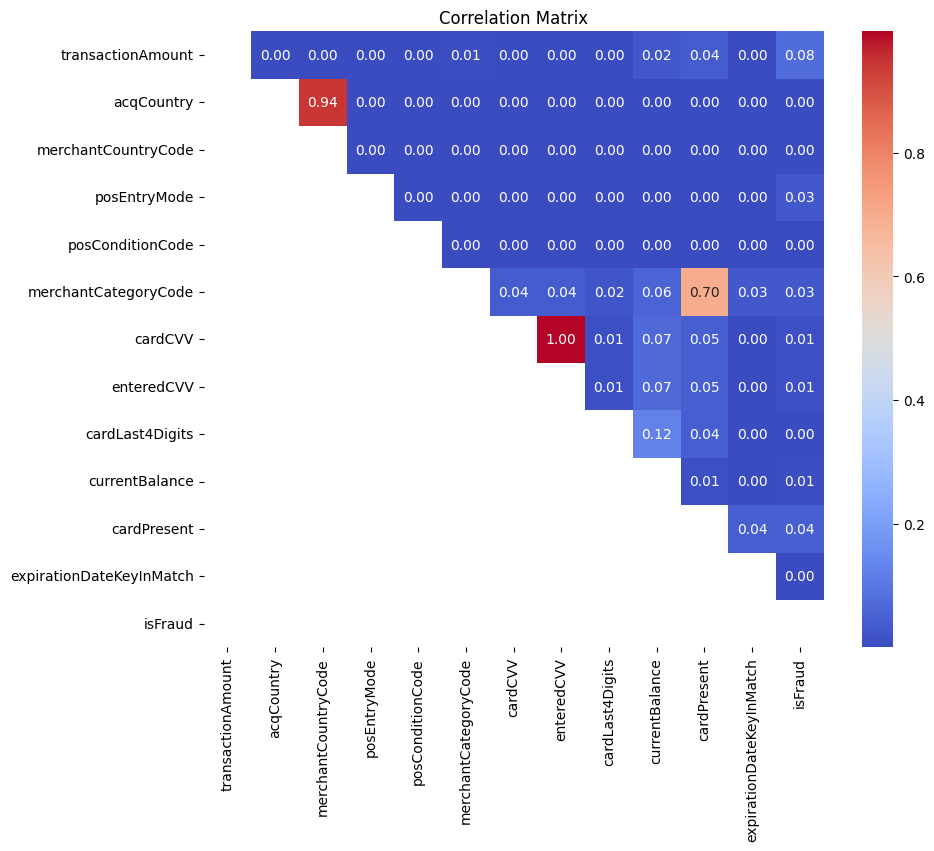

In [18]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(upper, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Using SMOTE to oversample the dataset
X = df.drop(['isFraud'], axis = 1)
y = df[['isFraud']]
sm = SMOTE(random_state=4)
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
print(y.isFraud.value_counts())
print(y_smote.isFraud.value_counts())

isFraud
0    773946
1     12417
Name: count, dtype: int64
isFraud
0    773946
1    773946
Name: count, dtype: int64


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=4)

### Fraud detection model 

* This link provide the previous study done on fraud detection - 
- https://www.avenga.com/magazine/fraud-detection-machine-learning/#:~:text=K%2Dmeans%20and%20SOM%20have,transaction%20classifications%20in%20fraud%20scenarios.
- https://sqream.com/blog/fraud-detection-machine-learning/

In [14]:
# Define the RandomizedSearchCV
RSC_DT = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions={
        'criterion': ['gini', 'entropy'],
        'max_depth': range(1, 100, 10),
        'max_features': [None, 'sqrt', 'log2']
    },
    cv=3, scoring='roc_auc', n_jobs=-1, verbose=True
)

# Fit RandomizedSearchCV to find best hyperparameters
search_result_DT = RSC_DT.fit(X_smote, y_smote)

# Build DecisionTreeClassifier with optimized hyperparameters
model_DT = DecisionTreeClassifier(
    criterion=search_result_DT.best_params_["criterion"],
    max_depth=search_result_DT.best_params_["max_depth"],
    max_features=search_result_DT.best_params_["max_features"]
)

# Fit the model to your training data
model_DT.fit(X_train, y_train)

# Make predictions on the test set
y_pred_DT = model_DT.predict(X_test)

# Evaluate the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred_DT))

DT_conf_matrix = confusion_matrix(y_test, y_pred_DT)
print("Confusion Matrix:")
print(DT_conf_matrix)

print("ROC-AUC Score:")
roc_auc_DT = roc_auc_score(y_test, model_DT.predict_proba(X_test)[:, 1])

accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = calculate_metrics(y_test, y_pred_DT)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    154570
           1       0.95      0.96      0.95    155009

    accuracy                           0.95    309579
   macro avg       0.95      0.95      0.95    309579
weighted avg       0.95      0.95      0.95    309579

Confusion Matrix:
[[145910   8660]
 [  5869 149140]]
ROC-AUC Score:
Accuracy: 0.9531
Precision: 0.9451
Recall: 0.9621
F1 Score: 0.9536


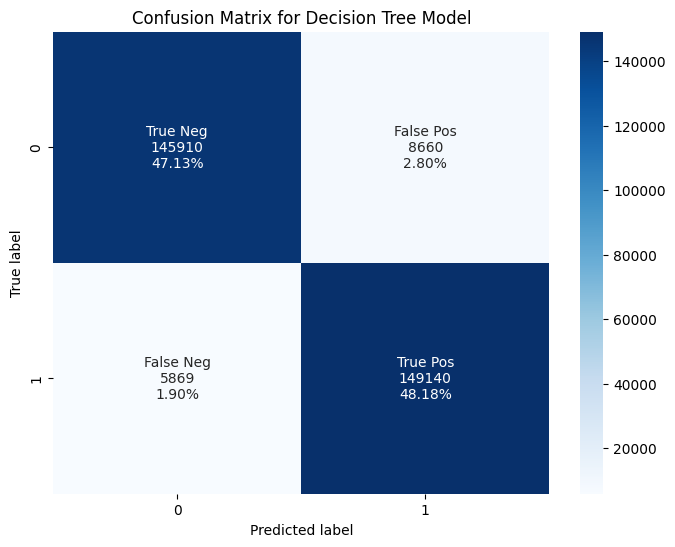

In [15]:
plt.figure(figsize=(8, 6))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in DT_conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in DT_conf_matrix.flatten()/np.sum(DT_conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(DT_conf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.show()

Confusion Matrix

I uses this reference link for my Confusion Matrix: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

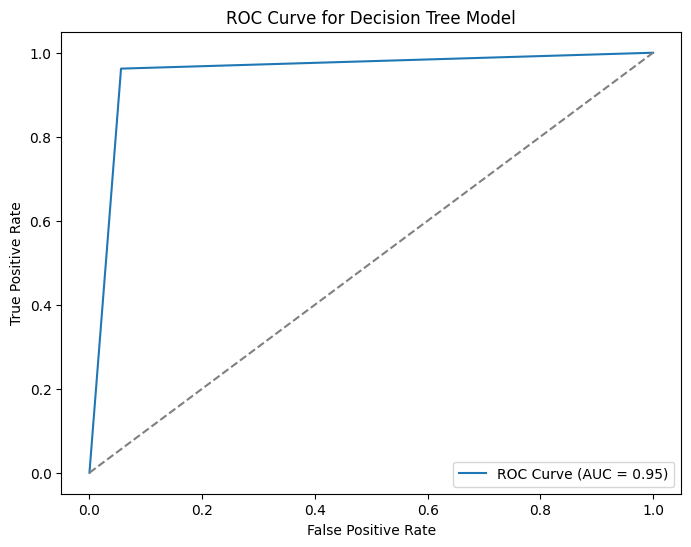

In [16]:
# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model_DT.predict_proba(X_test)[:, 1])

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_DT))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Model')
plt.legend(loc='lower right')
plt.show()

ROC Curve

I uses this reference link for my ROC Curve: https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/

We can see our model has a very good ROC Curve of 0.95

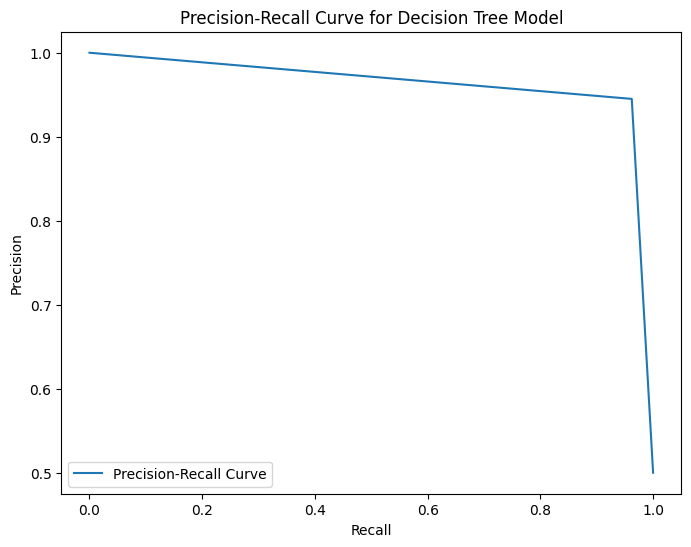

In [17]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_DT.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree Model')
plt.legend(loc='lower left')
plt.show()

Precision-Recall Curve

I uses this reference link for my Precision-Recall Curve: https://analyticsindiamag.com/complete-guide-to-understanding-precision-and-recall-curves/

We can see our model has a very good Precision-Recall Curve

#Decision Tree

A decision tree is a predictive modeling technique that maps out possible outcomes of a decision based on certain conditions. It recursively splits the data into subsets, with each split optimizing the separation of classes or maximizing information gain. Decision trees are intuitive, easy to interpret, and widely used in classification and regression tasks.

If I have enough time:

* I will test different column attribute to build different #Decision Tree model and observe the performance of the model
* I will explore other methods listed in this link 

https://sqream.com/blog/fraud-detection-machine-learning/
